In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import jax.numpy as jnp


# GMM

In [2]:
from jaxopt import LevenbergMarquardt


In [3]:
# Step 1: Generate a Synthetic Dataset
np.random.seed(42)

def dgp(b = np.array([1, 2]), N = 1_000, K = 3):
    # Instruments
    Z = np.random.normal(0, 1, (N, K))
    # Covariates
    pi = np.random.uniform(1, 2, K)
    w = Z @ pi + np.random.normal(0, 1, N)
    X = np.c_[np.ones(N), w]
    # Outcome
    y = X @ b + np.random.normal(0, 1, N)
    return {"y": y, "X": X, "Z": Z}


In [4]:
def moment_cond(b, dat):
    y, X, Z = jnp.array(dat['y']), jnp.array(dat['X']), jnp.array(dat['Z'])
    resid = y - X @ b
    return jnp.array(Z * resid[:, None])


In [5]:
gn = LevenbergMarquardt(moment_cond)
x_init = jnp.array([1., 1.])
gn.run(x_init,
       dat = dgp(b = np.array([2.1, -2]), K = 10)
       ).params


Array([ 2.0737247, -1.9924636], dtype=float32)

## balancing weights

In [6]:
import jaxopt as jo
import empirical_calibration as ec
import matplotlib.pyplot as plt
from tqdm import tqdm

from jax import config
config.update("jax_enable_x64", True)


In [29]:
def eb_moment(b, X0, X1):
    return jnp.log(jnp.exp(-1 * X0 @ b).sum()) + X1 @ b

def ebwt(X0, X1):
    solver = jo.LBFGS(fun=eb_moment, maxiter=100)
    res = solver.run(np.random.rand(X0.shape[1]), X0 = X0, X1 = X1)
    wt = np.exp(-1 * X0 @ res.params)
    wt /= wt.sum()
    return wt

def onesim():
    sim = ec.data.kang_schafer.Simulation(size=1000)
    w, y, X = sim.treatment, sim.outcome, np.c_[np.repeat(1, 1000), sim.covariates]
    X0, X1 = X[w == 0, :], X[w == 1, :].mean(0)
    wt = ebwt(X0, X1)
    naive = y[w == 1].mean() - y[w == 0].mean()
    wtd = y[w == 1].mean() - np.average(y[w == 0], weights=wt)
    return naive, wtd

onesim()


(-23.1364003479338, 0.03647455834061475)

In [8]:
res = [onesim() for _ in tqdm(range(100))]


100%|██████████| 100/100 [02:09<00:00,  1.30s/it]


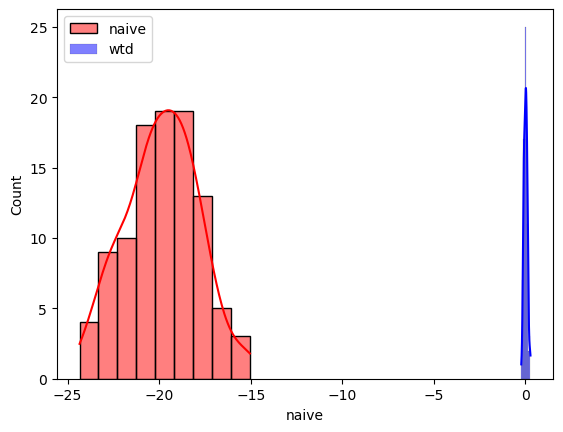

In [23]:
simres = pd.DataFrame(res, columns = ['naive', 'wtd'])

sns.histplot(simres['naive'], color = 'red', alpha = 0.5, kde = True,
             label = 'naive')
sns.histplot(simres['wtd'], color = 'blue', alpha = 0.5, kde = True,
             label = 'wtd')
plt.legend()
